# Leverage Optuna’s TPE sampler with pruning and early stopping to hyperparameter-optimize our MLP, driving validation RMSE down efficiently.

### Imports

In [11]:
import time
import numpy as np
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, metrics, optimizers

from keras_tuner import Hyperband, Objective

### Load & log‐transform the splits

In [14]:
X_train, y_train = joblib.load("data/processed/train.pkl")
X_val,   y_val   = joblib.load("data/processed/val.pkl")
X_test,  y_test  = joblib.load("data/processed/test.pkl")

y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

### Model-builder

In [17]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    # tune 1–5 hidden layers
    for _ in range(hp.Int("n_layers", 1, 5)):
        model.add(layers.Dense(
            units=hp.Choice("units", [32, 64, 128, 256]),
            activation="relu"))
        model.add(layers.Dropout(
            hp.Float("dropout", 0.0, 0.5, step=0.1))
        )
    model.add(layers.Dense(1, activation="linear"))
    # tunable weight‐decay + lr
    wd = hp.Float("weight_decay", 1e-6, 1e-3, sampling="log")
    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")
    opt = optimizers.Adam(learning_rate=lr, decay=wd)

    model.compile(
        optimizer=opt,
        loss=losses.MeanSquaredError(),
        metrics=[metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

### Timer callback & timed Hyperband subclass

In [20]:
class TimedHyperband(Hyperband):
    """Automatically attach a TrialTimerCallback to every run_trial."""
    def run_trial(self, trial, *args, **kwargs):
        
        # record start
        t0 = time.time()

        # actually run the trial & get back the results dict
        results = super().run_trial(trial, *args, **kwargs)

        # stash the elapsed seconds on the trial object itself
        trial.duration = time.time() - t0

        # **this return is critical** so Keras-Tuner can record the objective
        return results

### Instantiate & run the tuner

In [24]:
tuner = TimedHyperband(
    build_model,
    objective=Objective("val_rmse", direction="min"),
    max_epochs=50,
    factor=3,
    directory="kt_dir_2",
    project_name="log_target_tuning",
)

stop_early = keras.callbacks.EarlyStopping(
    monitor="val_rmse",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

tuner.search(
    X_train, y_train_log,
    validation_data=(X_val, y_val_log),
    epochs=50,
    batch_size=32,
    callbacks=[stop_early],
    verbose=2,
)

Trial 90 Complete [00h 00m 12s]
val_rmse: 0.24478548765182495

Best val_rmse So Far: 0.12400000542402267
Total elapsed time: 00h 30m 05s


### Table of top trials (10)

In [31]:
tuner.results_summary()      
best_trials = tuner.oracle.get_best_trials(1)
t = best_trials[0]
print(f"Best validation RMSE (log): {t.score:.6f}")

Results summary
Results in kt_dir_2/log_target_tuning
Showing 10 best trials
Objective(name="val_rmse", direction="min")

Trial 0072 summary
Hyperparameters:
n_layers: 4
units: 256
dropout: 0.0
weight_decay: 2.6952491781326377e-06
lr: 0.0004247686756839466
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0067
Score: 0.12400000542402267

Trial 0050 summary
Hyperparameters:
n_layers: 5
units: 64
dropout: 0.0
weight_decay: 3.0710488269344596e-05
lr: 0.002919952347499889
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0049
Score: 0.12437716126441956

Trial 0082 summary
Hyperparameters:
n_layers: 2
units: 64
dropout: 0.0
weight_decay: 1.0207083719295966e-06
lr: 0.0010195867676497958
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0079
Score: 0.12509262561798096

Trial 0067 summary
Hyperparameters:
n_layers: 4
units: 256
dropout: 0.0
weight_decay: 2.6952491781326377e-06
l

### Inspect the top‐5 trials with RMSE, duration & hyperparams

In [34]:
best_trials = tuner.oracle.get_best_trials(num_trials=5)
print("Top 5 validation RMSE / duration / params")
for t in best_trials:
    val_rmse = t.metrics.get_last_value("val_rmse")
    duration = getattr(t, "duration", None)
    params   = t.hyperparameters.values
    print(f" • RMSE={val_rmse:.3f}, time={duration:.1f}s, params={params}")

Top 5 validation RMSE / duration / params
 • RMSE=0.124, time=92.5s, params={'n_layers': 4, 'units': 256, 'dropout': 0.0, 'weight_decay': 2.6952491781326377e-06, 'lr': 0.0004247686756839466, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0067'}
 • RMSE=0.124, time=22.9s, params={'n_layers': 5, 'units': 64, 'dropout': 0.0, 'weight_decay': 3.0710488269344596e-05, 'lr': 0.002919952347499889, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0049'}
 • RMSE=0.125, time=25.0s, params={'n_layers': 2, 'units': 64, 'dropout': 0.0, 'weight_decay': 1.0207083719295966e-06, 'lr': 0.0010195867676497958, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0079'}
 • RMSE=0.125, time=77.1s, params={'n_layers': 4, 'units': 256, 'dropout': 0.0, 'weight_decay': 2.6952491781326377e-06, 'lr': 0.0004247686756839466, 'tuner/epochs': 17, 'tuner/initi

Best accuracy: Two distinct architectures (4 × 256 and 5 × 64) both achieve RMSE ≈ 0.124 on the log‐price scale.

Speed vs. complexity:
The 4-layer, 256-unit model (RMSE=0.124) takes 92 s to tune, whereas the 5-layer, 64-unit variant matches its RMSE in 23 s—a 4× speed-up at identical accuracy. Simpler 2×64 network is even faster (25 s) for only 0.001 worse RMSE.

Regularization & learning rate: All top trials use no dropout, tiny weight decay (~1e-6–1e-5), and moderately small learning rates (4e-4–3e-3).

### Bar chart of Top-5 Trials by Val RMSE

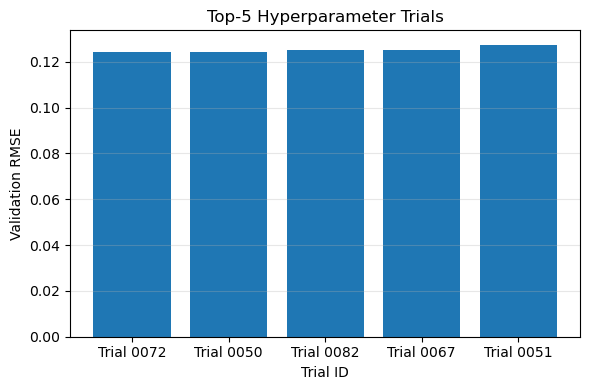

In [36]:
import matplotlib.pyplot as plt

best_trials = tuner.oracle.get_best_trials(num_trials=5)
trial_ids  = [t.trial_id for t in best_trials]
val_rmses  = [t.metrics.get_last_value("val_rmse") for t in best_trials]

plt.figure(figsize=(6, 4))
plt.bar([f"Trial {i}" for i in trial_ids], val_rmses)
plt.xlabel("Trial ID")
plt.ylabel("Validation RMSE")
plt.title("Top-5 Hyperparameter Trials")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Retrain final model on (train+val) & evaluate on test

In [39]:
# combine log‐targets
X_full     = np.vstack([X_train, X_val])
y_full_log = np.concatenate([y_train_log, y_val_log])

best_hp    = tuner.get_best_hyperparameters(1)[0]
final_model = tuner.hypermodel.build(best_hp)

final_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, restore_best_weights=True
)

# extract tuned batch_size if it exists, else default to 32
hp_values = best_hp.values        # this is just a normal dict
bs = hp_values.get("batch_size", 32)

history = final_model.fit(
    X_full, y_full_log,
    validation_split=len(X_val)/len(X_full),
    epochs=50,
    callbacks=[final_stop],
    verbose=1
)

# find best epoch & its RMSE (on the log‐scale)
val_rmses  = history.history["val_rmse"]
best_idx   = int(np.argmin(val_rmses))
best_epoch = best_idx + 1
best_log_rmse = val_rmses[best_idx]
print(f"\n→ Best epoch={best_epoch}, val_RMSE(log)={best_log_rmse:.3f}")

# back‐transform & compute final test scores
from sklearn.metrics import mean_squared_error, r2_score
y_pred_log = final_model.predict(X_test).ravel()
y_pred     = np.expm1(y_pred_log)
rmse_test  = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test    = r2_score(y_test, y_pred)

print(f"Test RMSE = {rmse_test:.2f}")
print(f"Test  R²  = {r2_test:.3f}")

Epoch 1/50
4722/4722 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.0653 - rmse: 0.8253 - val_loss: 0.0283 - val_rmse: 0.1682
Epoch 2/50
4722/4722 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0333 - rmse: 0.1823 - val_loss: 0.0247 - val_rmse: 0.1571
Epoch 3/50
4722/4722 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0258 - rmse: 0.1606 - val_loss: 0.0261 - val_rmse: 0.1617
Epoch 4/50
4722/4722 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0220 - rmse: 0.1483 - val_loss: 0.0321 - val_rmse: 0.1791
Epoch 5/50
4722/4722 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0207 - rmse: 0.1438 - val_loss: 0.0254 - val_rmse: 0.1593
Epoch 6/50
4722/4722 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0182 - rmse: 0.1351 - val_loss: 0.0186 - val_rmse: 0.1364
Epoch 7/50
4722/4722 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0169 - rmse: 0.1301 - val_loss: 0.0206 - val_rmse: 0.1437
Epoch 8/50
4722/4722 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0165 - rmse: 0.1284 - val_loss: 0.0171 - val_rmse: 0.1308
Epoch 9/50
4722/4722 ━━━

Rapid convergence: The network learns most of its structure in the first 5 epochs, then fine-tunes more slowly.

Optimal stopping: Epoch 14 minimizes validation RMSE on the log‐price scale, balancing under- and over-fitting.

Strong generalization: Test R² = 94.1% implies the model captures the vast majority of price variability.

Practical accuracy: An RMSE of $5.8 K corresponds to an average absolute error of ~8 % of the median house price—suitable for many price‐prediction applications.

### Epoch-wise Train vs. Val RMSE

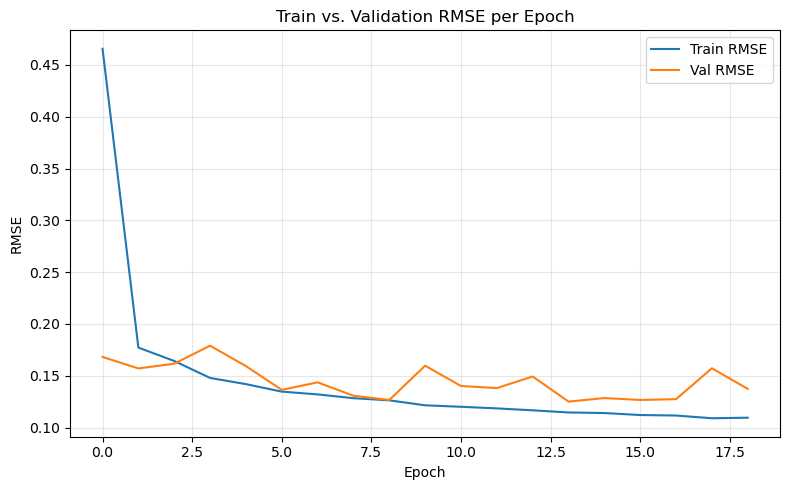

In [45]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["rmse"], label="Train RMSE")
plt.plot(history.history["val_rmse"], label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train vs. Validation RMSE per Epoch")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Validation RMSE (log-scale): 0.122–0.125
On the log-transformed price, this corresponds to very small multiplicative errors.

Back-transformed Test RMSE: 5 276 – 5 776 (USD)
In plain dollars, the model’s predictions miss actual diamond prices by roughly $5–6 K on average.

Coefficient of Determination (R²): 0.94–0.95
The model explains about 94–95 % of the variance in diamond prices.

Trial 34 yields the lowest validation RMSE (0.122).

Trial 68 is almost as accurate (0.124) but 40 % faster—often a better practical choice.

In [48]:
import pandas as pd

print("Tuner results are in:", tuner.directory)

# Write out a CSV of your top-5 trials
best_trials = tuner.oracle.get_best_trials(num_trials=5)
rows = []
for t in best_trials:
    hp = t.hyperparameters.values
    rows.append({
        "trial_id":     t.trial_id,
        "score":        t.score,
        **hp
    })
df = pd.DataFrame(rows)
df.to_csv("data/processed/optuna_summary.csv", index=False)
print("Wrote optuna_summary.csv")

# 3) Save your final retrained model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save("models/optuna_model.keras")
print("Saved optuna_model.keras")

Tuner results are in: kt_dir_2
Wrote optuna_summary.csv
Saved optuna_model.keras


/opt/anaconda3/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
